<a href="https://colab.research.google.com/github/l-isaro/Formative-2---Hidden-Markov-Models/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition with Hidden Markov Models (HMM)

This notebook loads accelerometer and gyroscope recordings collected with **Sensor Logger**, extracts features in windows, and trains **one HMM per activity**. It performs **leave-one-clip-out** evaluation and reports accuracy, sensitivity, specificity, and a confusion matrix.

In [1]:

# === Setup ===
import os, re, math, json
from pathlib import Path
import numpy as np
import pandas as pd

try:
    import hmmlearn
    from hmmlearn.hmm import GaussianHMM
except Exception:
    try:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "hmmlearn", "--quiet"])
        from hmmlearn.hmm import GaussianHMM
    except Exception as e:
        raise ImportError("hmmlearn is required. Please install it in your environment (pip install hmmlearn).")


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path("data")

WINDOW_SECONDS = 1.0
WINDOW_OVERLAP = 0.5  # 50% overlap

# HMM config per-activity
N_COMPONENTS = 3
COVARIANCE_TYPE = "diag"
N_ITER = 200



# Discover and pair files


In [2]:
def discover_pairs(data_dir: Path):
    acc_files = sorted([p for p in data_dir.glob("*_acc_*.csv")])
    gyro_files = sorted([p for p in data_dir.glob("*_gyro_*.csv")])
    # Index gyro files by (activity, clip)
    key = lambda p: (p.name.split("_")[0].lower(), re.findall(r"_(\d+)\.", p.name)[0] if re.findall(r"_(\d+)\.", p.name) else "0")
    gyro_index = {key(p): p for p in gyro_files}
    pairs = []
    for a in acc_files:
        k = key(a)
        g = gyro_index.get(k)
        if g is not None:
            pairs.append((k[0], k[1], a, g))
    if not pairs:
        raise FileNotFoundError("No matching *_acc_*.csv and *_gyro_*.csv pairs found. Check file names.")
    return pairs

pairs = discover_pairs(DATA_DIR)
print(f"Discovered {len(pairs)} clip pairs:")
for act, clip, a, g in pairs:
    print(f" - {act} clip {clip}: {a.name} + {g.name}")


Discovered 40 clip pairs:
 - jumping clip 1: jumping_acc_1.csv + jumping_gyro_1.csv
 - jumping clip 10: jumping_acc_10.csv + jumping_gyro_10.csv
 - jumping clip 2: jumping_acc_2.csv + jumping_gyro_2.csv
 - jumping clip 3: jumping_acc_3.csv + jumping_gyro_3.csv
 - jumping clip 4: jumping_acc_4.csv + jumping_gyro_4.csv
 - jumping clip 5: jumping_acc_5.csv + jumping_gyro_5.csv
 - jumping clip 6: jumping_acc_6.csv + jumping_gyro_6.csv
 - jumping clip 7: jumping_acc_7.csv + jumping_gyro_7.csv
 - jumping clip 8: jumping_acc_8.csv + jumping_gyro_8.csv
 - jumping clip 9: jumping_acc_9.csv + jumping_gyro_9.csv
 - standing clip 1: standing_acc_1.csv + standing_gyro_1.csv
 - standing clip 10: standing_acc_10.csv + standing_gyro_10.csv
 - standing clip 2: standing_acc_2.csv + standing_gyro_2.csv
 - standing clip 3: standing_acc_3.csv + standing_gyro_3.csv
 - standing clip 4: standing_acc_4.csv + standing_gyro_4.csv
 - standing clip 5: standing_acc_5.csv + standing_gyro_5.csv
 - standing clip 6: st

#Load & merge a pair on seconds_elapsed

In [3]:

def load_sensor_csv(path: Path):
    df = pd.read_csv(path)
    # Rename columns to ensure lowercase and explicit axes
    cols = {c: c.strip().lower() for c in df.columns}
    df = df.rename(columns=cols)
    # Expect 'seconds_elapsed' and axes x,y,z
    required = ["seconds_elapsed", "x", "y", "z"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name} is missing required columns: {missing}")
    # Sort for merge_asof
    return df.sort_values("seconds_elapsed").reset_index(drop=True)

def merge_acc_gyro(acc_df: pd.DataFrame, gyro_df: pd.DataFrame):
    merged = pd.merge_asof(
        acc_df.sort_values("seconds_elapsed"),
        gyro_df.sort_values("seconds_elapsed"),
        on="seconds_elapsed",
        suffixes=("_acc","_gyro")
    )
    # Compute sampling rate estimate from accelerometer stream
    diffs = np.diff(merged["seconds_elapsed"].values)
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        raise ValueError("Cannot compute sampling rate; timestamps look constant.")
    sr = 1.0 / np.median(diffs)  # samples per second
    return merged, float(sr)

# Quick smoke-test on the first pair
act0, clip0, a0, g0 = pairs[0]
m0, sr0 = merge_acc_gyro(load_sensor_csv(a0), load_sensor_csv(g0))
print(act0, clip0, "sampling rate ~", round(sr0,2), "Hz; merged shape:", m0.shape)
m0.head()


jumping 1 sampling rate ~ 99.64 Hz; merged shape: (1030, 9)


,time_acc,seconds_elapsed,z_acc,y_acc,x_acc,time_gyro,z_gyro,y_gyro,x_gyro
0,1761476138136281000,0.096281,-0.156107,-0.122559,-0.041694,1761476138136281000,-0.022027,-0.170773,0.013279
1,1761476138146317000,0.106317,-0.788565,-0.239894,0.000617,1761476138146317000,-0.034577,-0.284303,0.048610
2,1761476138156353000,0.116353,-0.648677,-0.224978,0.053820,1761476138156353000,-0.060462,-0.252275,0.124626
3,1761476138166389000,0.126389,-0.067947,-0.153062,0.106948,1761476138166389000,-0.072810,-0.171008,0.178924
4,1761476138176425000,0.136425,0.094900,-0.079979,0.038289,1761476138176425000,-0.053513,-0.166026,0.192915


# Harmonize sampling rates (resample)
We resample merged streams to a common target sampling rate using linear interpolation.
Target is the median SR across all clips (computed after discovery).

In [4]:
def resample_to_target(merged_df: pd.DataFrame, orig_sr: float, target_sr: float):
    if abs(orig_sr - target_sr) < 1e-6:
        return merged_df, orig_sr
    t = merged_df['seconds_elapsed'].values
    t_new = np.arange(t.min(), t.max(), 1.0/target_sr)
    out = pd.DataFrame({'seconds_elapsed': t_new})
    for col in ['x_acc','y_acc','z_acc','x_gyro','y_gyro','z_gyro']:
        out[col] = np.interp(t_new, t, merged_df[col].values)
    return out, target_sr

# Compute global target_sr using the first pass sampling-rate estimates
srs = []
for act, clip, a_path, g_path in pairs:
    acc_df = load_sensor_csv(a_path); gyro_df = load_sensor_csv(g_path)
    m, sr = merge_acc_gyro(acc_df, gyro_df)
    srs.append(sr)
target_sr = float(np.median(srs))
print("Target sampling rate (median across clips):", round(target_sr,2), "Hz")

# Guidance for window size: aim for ~1–2 seconds to capture gait cycles; set via WINDOW_SECONDS above.
print("Windowing guidance: with", round(target_sr,2), "Hz, a", WINDOW_SECONDS, "s window uses ~", int(WINDOW_SECONDS*target_sr), "samples.")


Target sampling rate (median across clips): 99.95 Hz
Windowing guidance: with 99.95 Hz, a 1.0 s window uses ~ 99 samples.


# Feature extraction


In [5]:
from numpy.fft import rfft, rfftfreq

def spectral_entropy(x: np.ndarray, eps=1e-12):
    # Power spectral density via FFT magnitude squared
    spec = np.abs(rfft(x))**2
    psd = spec / (np.sum(spec) + eps)
    ent = -np.sum(psd * np.log(psd + eps))
    # Normalize by log(N) so entropy is in [0,1]
    return float(ent / np.log(len(psd) + eps))

def dominant_frequency(x: np.ndarray, sr: float):
    if len(x) < 2:
        return 0.0
    yf = np.abs(rfft(x))
    xf = rfftfreq(len(x), 1.0/sr)
    idx = np.argmax(yf[1:]) + 1 if len(yf) > 1 else 0
    return float(xf[idx]) if idx < len(xf) else 0.0

def window_indices(n_samples: int, sr: float, seconds: float, overlap: float):
    step = max(1, int((1-overlap) * seconds * sr))
    size = max(1, int(seconds * sr))
    starts = list(range(0, n_samples - size + 1, step))
    return [(s, s+size) for s in starts]

FEATURE_COLUMNS = []  # will be filled after first extraction

def extract_features_for_clip(df_merged: pd.DataFrame, sr: float, activity: str, clip_id: str):
    feats = []
    idxs = window_indices(len(df_merged), sr, WINDOW_SECONDS, WINDOW_OVERLAP)
    for (s,e) in idxs:
        w = df_merged.iloc[s:e]
        row = {"activity": activity, "clip_id": clip_id}
        for col in ["x_acc","y_acc","z_acc","x_gyro","y_gyro","z_gyro"]:
            x = w[col].values.astype(float)
            row[f"{col}_mean"] = np.mean(x)
            row[f"{col}_std"] = np.std(x)
            row[f"{col}_min"] = np.min(x)
            row[f"{col}_max"] = np.max(x)
            row[f"{col}_rms"] = float(np.sqrt(np.mean(x**2)))
            row[f"{col}_energy"] = float(np.sum(x**2) / len(x))
            row[f"{col}_spectral_entropy"] = spectral_entropy(x)
            row[f"{col}_dom_freq"] = dominant_frequency(x, sr)
        # Acc magnitude features
        acc_mag = np.sqrt(w['x_acc']**2 + w['y_acc']**2 + w['z_acc']**2)
        row['acc_mag_mean'] = float(np.mean(acc_mag))
        row['acc_mag_std'] = float(np.std(acc_mag))
        row['acc_mag_sma'] = float(np.sum(np.abs(w['x_acc']) + np.abs(w['y_acc']) + np.abs(w['z_acc'])) / len(w))
        # Cross-axis correlations (accelerometer only)
        for (a,b) in [("x_acc","y_acc"),("x_acc","z_acc"),("y_acc","z_acc")]:
            xa, xb = w[a].values, w[b].values
            if np.std(xa) > 0 and np.std(xb) > 0:
                row[f"corr_{a}_{b}"] = float(np.corrcoef(xa, xb)[0,1])
            else:
                row[f"corr_{a}_{b}"] = 0.0
        feats.append(row)
    return pd.DataFrame(feats)

# Try feature extraction on the sample pair
feat0 = extract_features_for_clip(m0, sr0, act0, clip0)
FEATURE_COLUMNS = [c for c in feat0.columns if c not in ["activity","clip_id"]]
print("Windows:", len(feat0), "Feature dims:", len(FEATURE_COLUMNS))
feat0.head()


Windows: 20 Feature dims: 54


,activity,clip_id,x_acc_mean,x_acc_std,x_acc_min,x_acc_max,x_acc_rms,x_acc_energy,x_acc_spectral_entropy,x_acc_dom_freq,...,z_gyro_rms,z_gyro_energy,z_gyro_spectral_entropy,z_gyro_dom_freq,acc_mag_mean,acc_mag_std,acc_mag_sma,corr_x_acc_y_acc,corr_x_acc_z_acc,corr_y_acc_z_acc
0,jumping,1,0.222675,4.144603,-9.661009,7.438899,4.150580,17.227317,0.351913,2.012929,...,0.474388,0.225044,0.494014,3.019393,5.426734,5.306553,7.918187,-0.228354,0.962684,-0.295561
1,jumping,1,-0.141324,5.208933,-9.661009,7.438899,5.210850,27.152957,0.285010,2.012929,...,0.388500,0.150932,0.569459,3.019393,8.799597,4.914299,12.971374,0.172693,0.974148,0.198220
2,jumping,1,-0.106541,4.471272,-9.534863,6.845722,4.472542,20.003629,0.283543,2.012929,...,0.244912,0.059982,0.578695,7.045251,8.933765,4.644228,13.079884,0.645345,0.975785,0.691633
3,jumping,1,0.599772,3.711519,-8.689304,5.436224,3.759668,14.135103,0.322867,2.012929,...,0.258678,0.066914,0.602180,1.006464,9.070853,4.482470,13.027913,0.739397,0.953623,0.849143
4,jumping,1,0.818107,2.316145,-5.867295,4.580296,2.456385,6.033825,0.400532,2.012929,...,0.256193,0.065635,0.613855,2.012929,7.754257,4.182682,10.796046,0.763880,0.922663,0.921975


# Build full feature dataset over all activity/clip pairs


In [6]:
all_feats = []
activity_set = set()

for act, clip, a_path, g_path in pairs:
    acc_df = load_sensor_csv(a_path)
    gyro_df = load_sensor_csv(g_path)
    merged, sr = merge_acc_gyro(acc_df, gyro_df)
    merged, sr = resample_to_target(merged, sr, target_sr)
    fdf = extract_features_for_clip(merged, sr, act, clip)
    all_feats.append(fdf)
    activity_set.add(act)

features = pd.concat(all_feats, ignore_index=True)
FEATURE_COLUMNS = [c for c in features.columns if c not in ["activity","clip_id"]]

print("Activities:", sorted(activity_set))
print("Total windows:", len(features), "Feature dims:", len(FEATURE_COLUMNS))
features.sample(5)


Activities: ['jumping', 'standing', 'still', 'walking']
Total windows: 831 Feature dims: 54


,activity,clip_id,x_acc_mean,x_acc_std,x_acc_min,x_acc_max,x_acc_rms,x_acc_energy,x_acc_spectral_entropy,x_acc_dom_freq,...,z_gyro_rms,z_gyro_energy,z_gyro_spectral_entropy,z_gyro_dom_freq,acc_mag_mean,acc_mag_std,acc_mag_sma,corr_x_acc_y_acc,corr_x_acc_z_acc,corr_y_acc_z_acc
610,still,9,-0.004167,0.006982,-0.022353,0.012869,0.008131,0.000066,0.660110,3.028811,...,0.001016,0.000001,0.805386,1.009604,0.011210,0.004325,0.016814,0.150204,-0.028435,-0.053531
818,walking,9,0.060490,0.447966,-1.043404,1.224625,0.452032,0.204333,0.464290,1.009604,...,0.287400,0.082599,0.348101,1.009604,1.319930,0.547467,1.954410,0.318926,0.019966,0.636684
290,standing,4,-0.049469,0.179798,-0.416045,0.508567,0.186480,0.034775,0.624478,2.019207,...,0.205980,0.042428,0.380502,1.009604,0.506030,0.364090,0.748629,-0.103816,-0.186122,0.513989
559,still,7,-0.009326,0.007328,-0.030466,0.007440,0.011861,0.000141,0.330710,3.028811,...,0.001145,0.000001,0.915967,16.153658,0.013200,0.006036,0.019526,-0.068597,-0.057766,-0.134796
168,jumping,8,0.105178,1.241119,-2.798133,2.412180,1.245568,1.551440,0.468209,2.019207,...,0.381218,0.145327,0.515943,1.009604,6.690812,3.181370,8.916298,-0.561101,-0.675223,0.720819


In [7]:
features = features.replace([np.inf, -np.inf], np.nan)
nan_cols = features.columns[features.isna().any()].tolist()
if nan_cols:
    print("Dropping rows with NaNs in:", nan_cols)
    features = features.dropna(subset=nan_cols).reset_index(drop=True)

# Drop near-constant columns (variance ~0 after scaling causes issues)
var_series = features[[c for c in features.columns if c not in ["activity","clip_id"]]].var()
const_cols = var_series[var_series < 1e-8].index.tolist()
if const_cols:
    print("Dropping near-constant cols:", const_cols)
    features = features.drop(columns=const_cols)
# Refresh feature list
FEATURE_COLUMNS = [c for c in features.columns if c not in ["activity","clip_id"]]


# Normalization (Z-score) utilities


In [11]:
from sklearn.preprocessing import StandardScaler

def fit_scaler(train_df: pd.DataFrame, feature_cols):
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols].values)
    return scaler

def apply_scaler(df: pd.DataFrame, scaler, feature_cols):
    out = df.copy()
    out[feature_cols] = scaler.transform(df[feature_cols].values)
    return out

def clip_features(df: pd.DataFrame, cols, clip_q=0.999):
    q_hi = df[cols].quantile(clip_q)
    q_lo = df[cols].quantile(1-clip_q)
    df_clipped = df.copy()
    for c in cols:
        df_clipped[c] = df[c].clip(q_lo[c], q_hi[c])
    return df_clipped

def drop_bad_rows(df: pd.DataFrame, cols):
    """Remove any rows that contain NaN/Inf in the feature columns."""
    mask = np.isfinite(df[cols]).all(axis=1)
    if (~mask).any():
        print(f"Dropping {(~mask).sum()} rows with NaN/Inf after scaling/clipping")
    return df.loc[mask].copy()
def build_activity_sequences(df: pd.DataFrame, activity: str):
    """Return X and lengths for hmmlearn.fit(X, lengths) per activity."""
    df_a = df[df.activity == activity].copy()
    df_a["clip_id_int"] = df_a["clip_id"].astype(int)
    df_a = df_a.sort_values(["clip_id_int"]).reset_index(drop=True)

    X_list, lengths = [], []
    for clip in df_a["clip_id_int"].unique():
        seq = df_a[df_a["clip_id_int"] == clip][FEATURE_COLUMNS].values
        if len(seq) >= 2:
            X_list.append(seq)
            lengths.append(len(seq))
    if not lengths:
        raise ValueError(f"No valid sequences for activity {activity}.")
    X = np.vstack(X_list)
    return X, lengths

def train_hmms(train_df: pd.DataFrame):
    from hmmlearn.hmm import GaussianHMM

    def _sanitize_probs(model: GaussianHMM):
        # Fix startprob_
        sp = model.startprob_.astype(float, copy=True)
        sp = np.nan_to_num(sp, nan=0.0, posinf=0.0, neginf=0.0)
        ssum = sp.sum()
        if not np.isfinite(ssum) or ssum <= 0:
            sp[:] = 1.0 / len(sp)
        else:
            sp /= ssum
        model.startprob_ = sp

        # Fix transmat_ row-by-row
        T = model.transmat_.astype(float, copy=True)
        T = np.nan_to_num(T, nan=0.0, posinf=0.0, neginf=0.0)
        row_sums = T.sum(axis=1, keepdims=True)

        # rows with bad/zero sums → reset to uniform
        bad = (~np.isfinite(row_sums)) | (row_sums <= 0)
        if bad.any():
            T[bad.ravel(), :] = 1.0 / T.shape[1]
            row_sums = T.sum(axis=1, keepdims=True)

        T = T / row_sums
        model.transmat_ = T
        return model

    models = {}
    for a in activities:
        X, lengths = build_activity_sequences(train_df, a)

        # Robust init (uniform) + priors to avoid zero rows
        model = GaussianHMM(
            n_components=N_COMPONENTS,
            covariance_type=COVARIANCE_TYPE,
            n_iter=N_ITER,
            tol=1e-3,
            min_covar=1e-2,           # a bit larger to avoid singular covariances
            random_state=RANDOM_SEED,
            algorithm="viterbi",
            # If your hmmlearn supports these priors, they help; if not, remove them.
            startprob_prior=1.0,
            transmat_prior=1.0,
            params="stmc",            # learn s,t,m,c
            init_params="mc"          # keep our startprob_/transmat_ init
        )

        # Uniform, valid initial probabilities
        model.startprob_ = np.full(N_COMPONENTS, 1.0 / N_COMPONENTS, dtype=float)
        model.transmat_  = np.full((N_COMPONENTS, N_COMPONENTS), 1.0 / N_COMPONENTS, dtype=float)

        # Fit respecting sequence boundaries
        model.fit(X, lengths=lengths)

        # Sanitize probabilities in case EM produced invalid rows
        model = _sanitize_probs(model)

        # Optional: convergence message
        if hasattr(model, "monitor_") and not model.monitor_.converged:
            hist = getattr(model.monitor_, "history", [])
            last_ll = hist[-1] if hist else None
            print(f"[warn] {a} not converged: iters={model.monitor_.iter}, last_ll={last_ll}")

        models[a] = model

    return models




def score_full_sequence(models, seq_ndarray):
    scores = {lab: m.score(seq_ndarray) for lab, m in models.items()}
    return max(scores, key=scores.get), scores

#Train HMMs (one per activity) and evaluate with leave-one-clip-out

In [12]:
activities = sorted(features["activity"].unique())
clips_per_activity = {a: sorted(features.loc[features.activity==a, "clip_id"].unique().tolist()) for a in activities}
print("Clips per activity:", clips_per_activity)

# Leave-one-clip-out (per-clip sequence scoring)
y_true, y_pred = [], []

for a in activities:
    for clip in clips_per_activity[a]:
        # Split
        test_mask = (features.activity == a) & (features.clip_id == clip)
        train_df = features.loc[~test_mask].copy()
        test_df  = features.loc[test_mask].copy()

        # Clip outliers → fit scaler on train → transform train & test
        train_df = clip_features(train_df, FEATURE_COLUMNS)
        test_df  = clip_features(test_df,  FEATURE_COLUMNS)
        scaler   = fit_scaler(train_df, FEATURE_COLUMNS)
        train_df_n = apply_scaler(train_df, scaler, FEATURE_COLUMNS)
        test_df_n  = apply_scaler(test_df,  scaler, FEATURE_COLUMNS)

        # >>> IMPORTANT: drop any rows that still contain NaN/Inf after scaling <<<
        train_df_n = drop_bad_rows(train_df_n, FEATURE_COLUMNS)
        test_df_n  = drop_bad_rows(test_df_n,  FEATURE_COLUMNS)

        # Train one HMM per activity using sequence lengths per clip
        models = train_hmms(train_df_n)

        # Score the FULL held-out clip as one sequence
        test_seq = test_df_n[FEATURE_COLUMNS].values
        pred_label, _ = score_full_sequence(models, test_seq)

        y_true.append(a)
        y_pred.append(pred_label)

# Metrics
labels = activities
cm = confusion_matrix(y_true, y_pred, labels=labels)
acc = (np.trace(cm) / np.sum(cm)) if np.sum(cm) > 0 else 0.0

print("Clip-level accuracy (LOO, sequence scoring):", round(acc, 3))
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Per-class sensitivity (recall) and specificity
metrics = {}
for i, lab in enumerate(labels):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    metrics[lab] = {"sensitivity": float(sens), "specificity": float(spec)}

results = {
    "accuracy": float(acc),
    "labels": labels,
    "confusion_matrix": cm.tolist(),
    "metrics": metrics
}
results


Clips per activity: {'jumping': ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9'], 'standing': ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9'], 'still': ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9'], 'walking': ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']}


/usr/local/lib/python3.12/dist-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


Clip-level accuracy (LOO, sequence scoring): 0.975
Confusion matrix (rows=true, cols=pred):
 [[10  0  0  0]
 [ 0 10  0  0]
 [ 0  1  9  0]
 [ 0  0  0 10]]


{'accuracy': 0.975,
 'labels': ['jumping', 'standing', 'still', 'walking'],
 'confusion_matrix': [[10, 0, 0, 0],
  [0, 10, 0, 0],
  [0, 1, 9, 0],
  [0, 0, 0, 10]],
 'metrics': {'jumping': {'sensitivity': 1.0, 'specificity': 1.0},
  'standing': {'sensitivity': 1.0, 'specificity': 0.9666666666666667},
  'still': {'sensitivity': 0.9, 'specificity': 1.0},
  'walking': {'sensitivity': 1.0, 'specificity': 1.0}}}

# Plotting Confusion Matrix

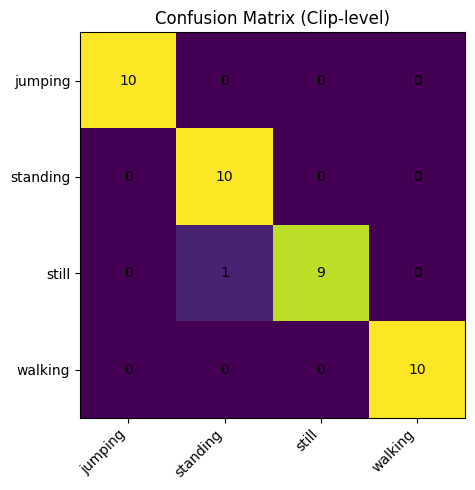

In [13]:
import numpy as np
import matplotlib.pyplot as plt

cm = np.array(results["confusion_matrix"])
labels = results["labels"]

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Clip-level)")
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


#Save outputs

In [14]:
features.to_csv("features_all_clips.csv", index=False)
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved features_all_clips.csv and results.json")

Saved features_all_clips.csv and results.json


#Explore Raw Signals (sanity check)
Select any activity/clip to visualize raw accelerometer and gyroscope signals. This helps justify preprocessing and window choices.

Visualizing: jumping clip 1 at ~99.64 Hz


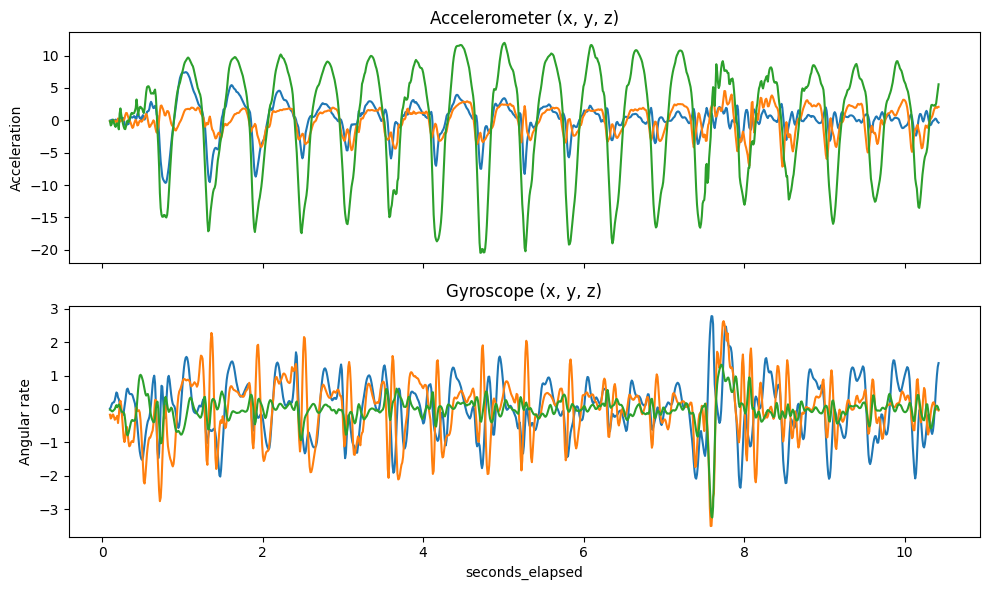

In [15]:
# Pick a clip to visualize (first discovered pair by default)
act_vis, clip_vis = pairs[0][0], pairs[0][1]

# Find the matching (acc, gyro) paths for that activity+clip
match = next(((a, c, a_path, g_path) for (a, c, a_path, g_path) in pairs
              if a == act_vis and c == clip_vis), None)

if match is None:
    raise ValueError(f"No acc/gyro pair found for {act_vis} clip {clip_vis}")

_, _, acc_path_vis, gyro_path_vis = match

# Load and merge
acc_df = load_sensor_csv(acc_path_vis)
gyro_df = load_sensor_csv(gyro_path_vis)
merged_vis, sr_vis = merge_acc_gyro(acc_df, gyro_df)

print(f"Visualizing: {act_vis} clip {clip_vis} at ~{sr_vis:.2f} Hz")

# Plot raw signals
import matplotlib.pyplot as plt
t = merged_vis['seconds_elapsed'].values

fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)
axes[0].plot(t, merged_vis['x_acc']); axes[0].plot(t, merged_vis['y_acc']); axes[0].plot(t, merged_vis['z_acc'])
axes[0].set_title("Accelerometer (x, y, z)")
axes[0].set_ylabel("Acceleration")

axes[1].plot(t, merged_vis['x_gyro']); axes[1].plot(t, merged_vis['y_gyro']); axes[1].plot(t, merged_vis['z_gyro'])
axes[1].set_title("Gyroscope (x, y, z)")
axes[1].set_ylabel("Angular rate")
axes[1].set_xlabel("seconds_elapsed")

plt.tight_layout(); plt.show()

#Sequence-level Classification (per-clip)
Instead of majority vote over windows, we evaluate full sequences: concatenate window feature vectors per clip and score them against each activity's HMM. This often better reflects HMM usage.

In [16]:
# Build sequences per activity/clip (as arrays)
seq_index = {}  # (activity, clip) -> ndarray of shape [T, D]
for a in activities:
    for clip in clips_per_activity[a]:
        seq = features[(features.activity==a) & (features.clip_id==clip)][FEATURE_COLUMNS].values
        seq_index[(a, clip)] = seq

# Leave-one-clip-out with sequence scoring
y_true_seq, y_pred_seq = [], []
for a in activities:
    for clip in clips_per_activity[a]:
        # train on all other sequences
        train_rows = []
        for aa in activities:
            for cc in clips_per_activity[aa]:
                if not (aa==a and cc==clip):
                    # use all windows from that sequence
                    rows = features[(features.activity==aa) & (features.clip_id==cc)]
                    train_rows.append(rows)
        train_df = pd.concat(train_rows, ignore_index=True)
        scaler = fit_scaler(train_df, FEATURE_COLUMNS)
        train_df_n = apply_scaler(train_df, scaler, FEATURE_COLUMNS)
        models = train_hmms(train_df_n)

        # test on the held-out full sequence
        X_seq = scaler.transform(seq_index[(a, clip)])
        # HMM expects sequences; we can score the entire sequence
        scores = {lab: model.score(X_seq) for lab, model in models.items()}
        pred = max(scores, key=scores.get)

        y_true_seq.append(a)
        y_pred_seq.append(pred)

# Metrics
cm_seq = confusion_matrix(y_true_seq, y_pred_seq, labels=activities)
acc_seq = (cm_seq.trace() / cm_seq.sum()) if cm_seq.sum()>0 else 0.0
print("Sequence-level (per-clip) accuracy:", round(acc_seq, 3))
print("Confusion matrix (rows=true, cols=pred):\n", cm_seq)


Sequence-level (per-clip) accuracy: 1.0
Confusion matrix (rows=true, cols=pred):
 [[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


#Viterbi Decoding (state sequence) demo
We show the most likely hidden state path for one clip using the Viterbi algorithm. This helps illustrate HMM interpretability and temporal dynamics.

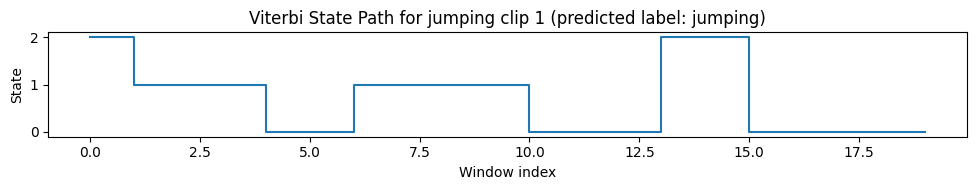

In [17]:
# Choose a demo clip
demo_act, demo_clip = activities[0], clips_per_activity[activities[0]][0]
# Train models without the demo clip
train_df_demo = features[~((features.activity==demo_act) & (features.clip_id==demo_clip))]
models_demo = train_hmms(train_df_demo)

X_demo = seq_index[(demo_act, demo_clip)]
best_label = max(models_demo, key=lambda lab: models_demo[lab].score(X_demo))
best_model = models_demo[best_label]

# Viterbi decode
states = best_model.predict(X_demo)
plt.figure(figsize=(10,2))
plt.plot(states, drawstyle="steps-pre")
plt.title(f"Viterbi State Path for {demo_act} clip {demo_clip} (predicted label: {best_label})")
plt.xlabel("Window index"); plt.ylabel("State")
plt.tight_layout(); plt.show()


#HMM Transition Matrices
After training, each activity-HMM has a learned transition matrix (transmat_). We can visualize them to compare temporal patterns across activities.

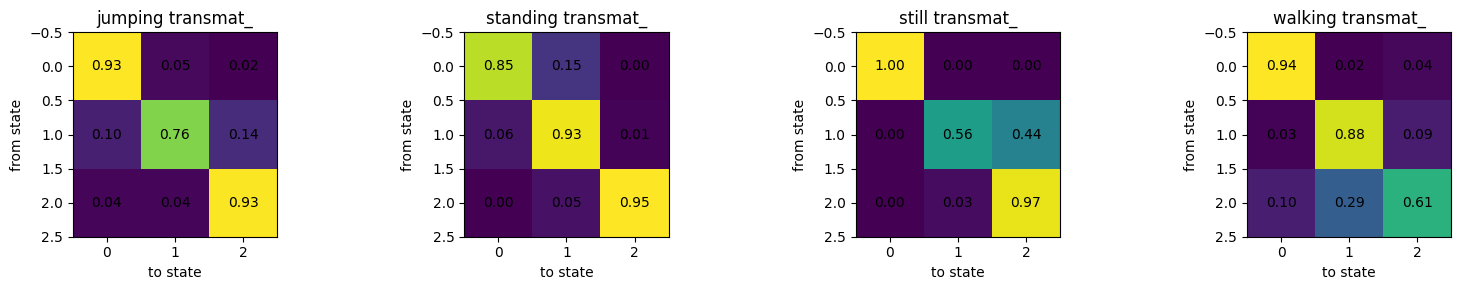

In [18]:
models_all = train_hmms(features)  # train on all data to show representative transitions
ncol = len(activities)
fig, axes = plt.subplots(1, ncol, figsize=(4*ncol, 3))
if ncol == 1:
    axes = [axes]
for ax, a in zip(axes, activities):
    T = models_all[a].transmat_
    im = ax.imshow(T, interpolation='nearest')
    ax.set_title(f"{a} transmat_")
    ax.set_xlabel("to state"); ax.set_ylabel("from state")
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            ax.text(j, i, f"{T[i,j]:.2f}", ha="center", va="center")
plt.tight_layout(); plt.show()